# ASAC EDA 프로젝트

## 서울시 자치구별 업종별 폐업률 데이터 수집

### 모듈 가져오기

In [1]:
# !pip install selenium==4.11.2

In [3]:
import selenium
from selenium import webdriver as wd 
import time

### Webdriver 실행

In [4]:
driver = wd.Chrome()

### 타겟 사이트 로드
- 서울시에서 운영하는 디지털 사장실(Seoul Smart City Platform)의 '우리마을 가게 상권분석' 페이지 링크 사용
- 해당 사이트에는 업종 선택이 가능하고 대분류, 중분류를 선택하여 각 업종에 대해 25개 자치구별 평균영업개월수, 점포수, 개업률, 폐업률, 3년생존율 데이터 제공  

![우리마을 가게 상권분석.PNG](<attachment:우리마을 가게 상권분석.PNG>)
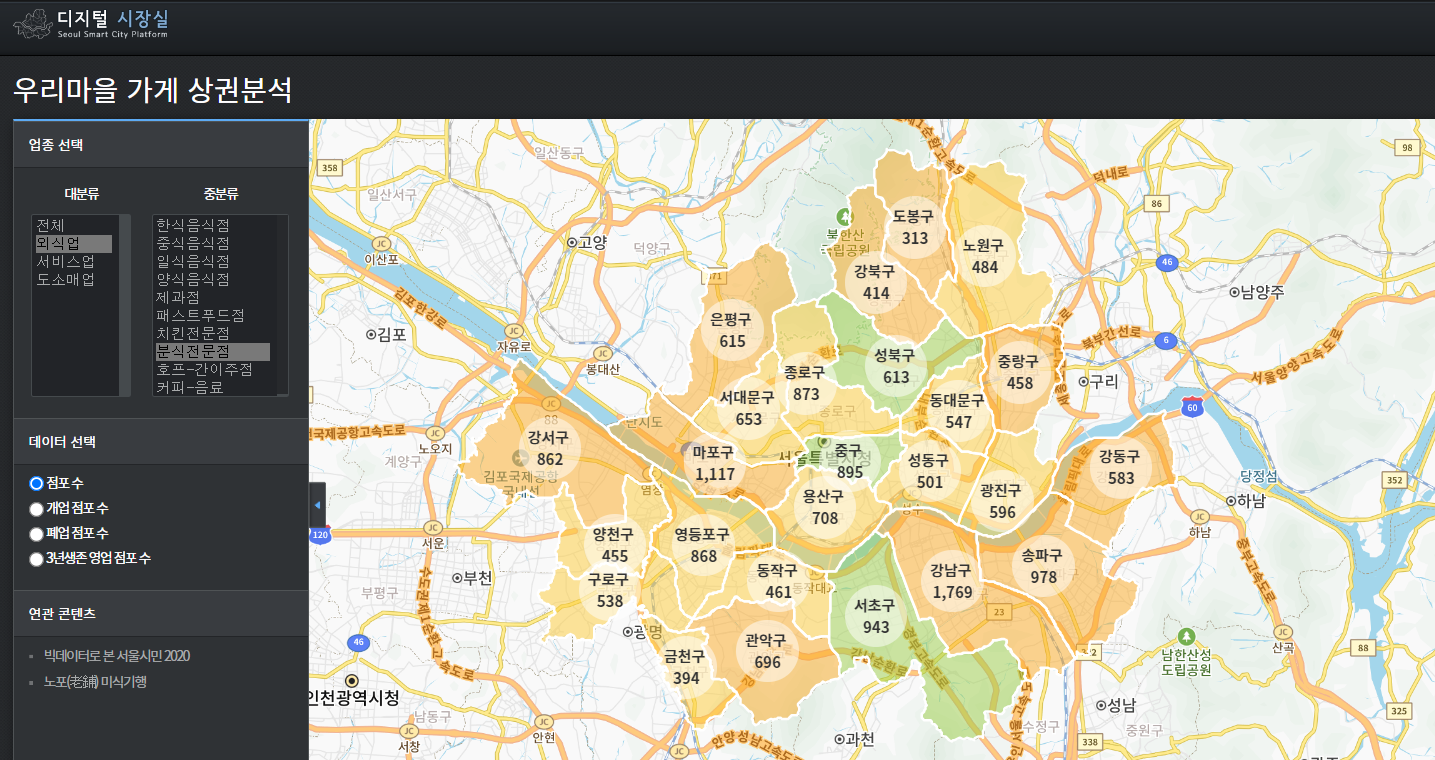

In [6]:
# 타겟 사이트 url을 통해 접근
target_site = 'https://scpm.seoul.go.kr/trdar/trdarMain?signguCd=11140&svcIndutyCd=CS100008'
driver.get(target_site)
time.sleep(2)

In [7]:
from selenium.webdriver.common.by import By
# 업종 대분류 css_selector 선택 및 클릭
css_selector_res = '#svc_induty_cd_sel_01 > option:nth-child(2)'
restaurant = driver.find_element(By.CSS_SELECTOR, css_selector_res)
print(restaurant.text)
restaurant.click()
time.sleep(1)

# 업종 중분류  css_selector 
css_selector_type = '#svc_induty_cd_sel_02 > option'
foodtypes = driver.find_elements(By.CSS_SELECTOR, css_selector_type)

외식업


- 업종대분류가 음식인 것중 업종중분류를 가져왔지만 총 100개의 항목이 가져와짐
- html 구조를 확인한 결과 모든 업종에 대한 option이 모두 같은 class 안에 속해있음


![업종중분류 항목.PNG](<attachment:업종중분류 항목.PNG>)
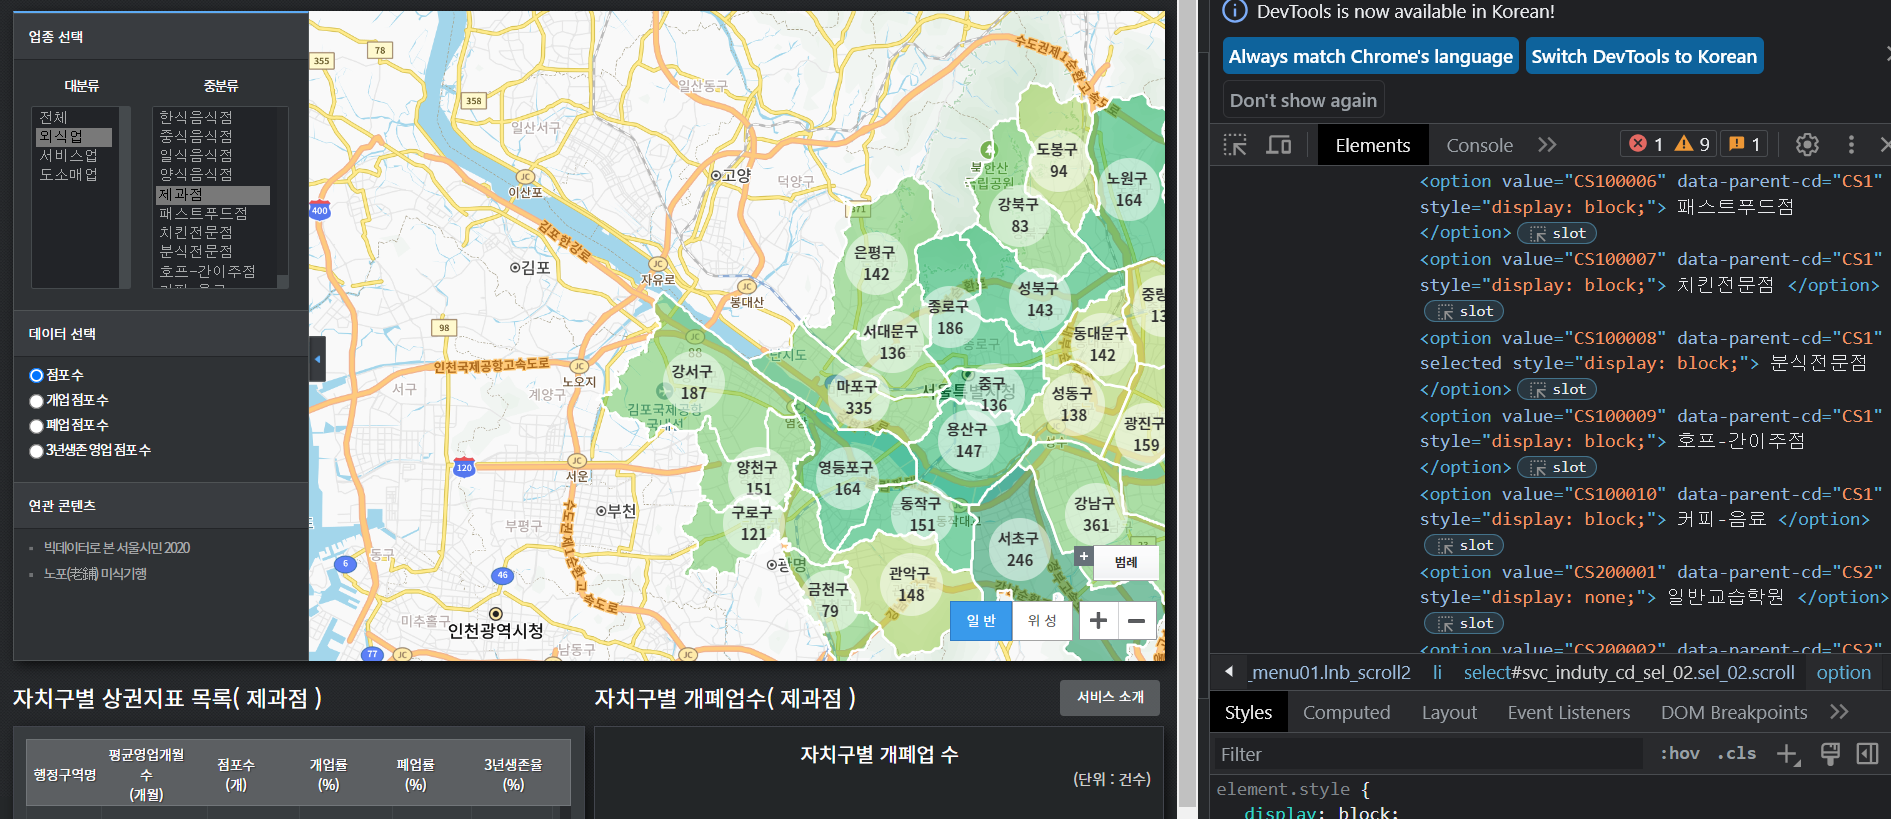

In [8]:
len(foodtypes)

100

- 확인 결과 업종대분류가 음식인 업종중분류는 10개로 상위 10개 option에 대한 것만 제한하여 스크래핑 진행

- 수집 대상 데이터 항목
    - 업종중분류명
    - 행정구역명
    - 평균영업개월수
    - 점포수
    - 개업률
    - 폐업률
    - 3년생존율

In [10]:
# 수집된 딕셔너리 형태의 데이터를 담을 수 있는 빈 리스트 준비
total_crawling = list()

# 총 100개의 업종중분류 중 10개에 대한 항목만 진행
for foodtype in foodtypes[:10]:
    # 업종분류명
    food = foodtype.text
    # 업종중분류 클릭
    foodtype.click()
    time.sleep(2)
    # tbody의 tr 
    rows = driver.find_elements(By.CSS_SELECTOR, '#market_info > tr')
    for row in rows:
        # tr의 각 자식들을 가져와 dict 형태로 정리
        data = {
            '업종분류명' : food,
            '행정구역명' : row.find_element(By.CSS_SELECTOR, 'td:nth-child(1)').text,
            '평균영업개월수(개월)' : row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').text ,
            '점포수(개)' : row.find_element(By.CSS_SELECTOR, 'td:nth-child(3)').text ,
            '개업률(%)' : row.find_element(By.CSS_SELECTOR, 'td:nth-child(4)').text,
            '폐업률(%)' : row.find_element(By.CSS_SELECTOR, 'td:nth-child(5)').text,
            '3년생존율(%)' : row.find_element(By.CSS_SELECTOR, 'td:nth-child(6)').text
        }
        # 빈리스트에 dict 추가
        total_crawling.append(data)


In [12]:
# 총 10개 업종에 대한 25개의 자치구 데이터 수집 완료
len(total_crawling)

250

In [17]:
# webdriver 종료
driver.close()

In [13]:
import pandas as pd
# 수집된 데이터를 데이터프레임으로 변환
seoul_close = pd.DataFrame(total_crawling)

In [15]:
seoul_close.shape, display(seoul_close)
# 데이터 프레임을 csv로 저장
# seoul_close.to_csv('업종별폐업률.csv', index = False)

,업종분류명,행정구역명,평균영업개월수(개월),점포수(개),개업률(%),폐업률(%),3년생존율(%)
0,한식음식점,종로구,37.7,"2,403",2.8,3.2,62
1,한식음식점,중구,37.3,"2,364",2.8,2.2,59.3
2,한식음식점,용산구,36.5,"1,487",3.1,2.6,55
3,한식음식점,성동구,34.7,"1,539",3.3,3.4,55.2
4,한식음식점,광진구,32.9,"1,731",3.7,4.1,49
...,...,...,...,...,...,...,...
245,커피-음료,관악구,29.9,654,6.1,4.1,54.1
246,커피-음료,서초구,33.4,"1,183",4.9,3.4,50
247,커피-음료,강남구,32.2,"1,987",4.6,2.6,53.1
248,커피-음료,송파구,30.4,"1,177",5.5,3.8,54.6


((250, 7), None)

## 지역구별 상가 임대료 스크래핑
- 서울시의 각 지역구의 평균 임대료 데이터를 수집하기 위해 상업용 부동산 사이트 Nemo 활용
- 지역구별 평균 권리금, 월세 정보가 있음
    - 단, 사이트 접근 시점에 사이트에 등록된 매물을 기준으로 데이터가 공개되어 있음
    - 수집된 데이터의 샘플이 모수를 대변할 수 있는지는 검증이 필요

![부동산 사이트.PNG](<attachment:부동산 사이트.PNG>)
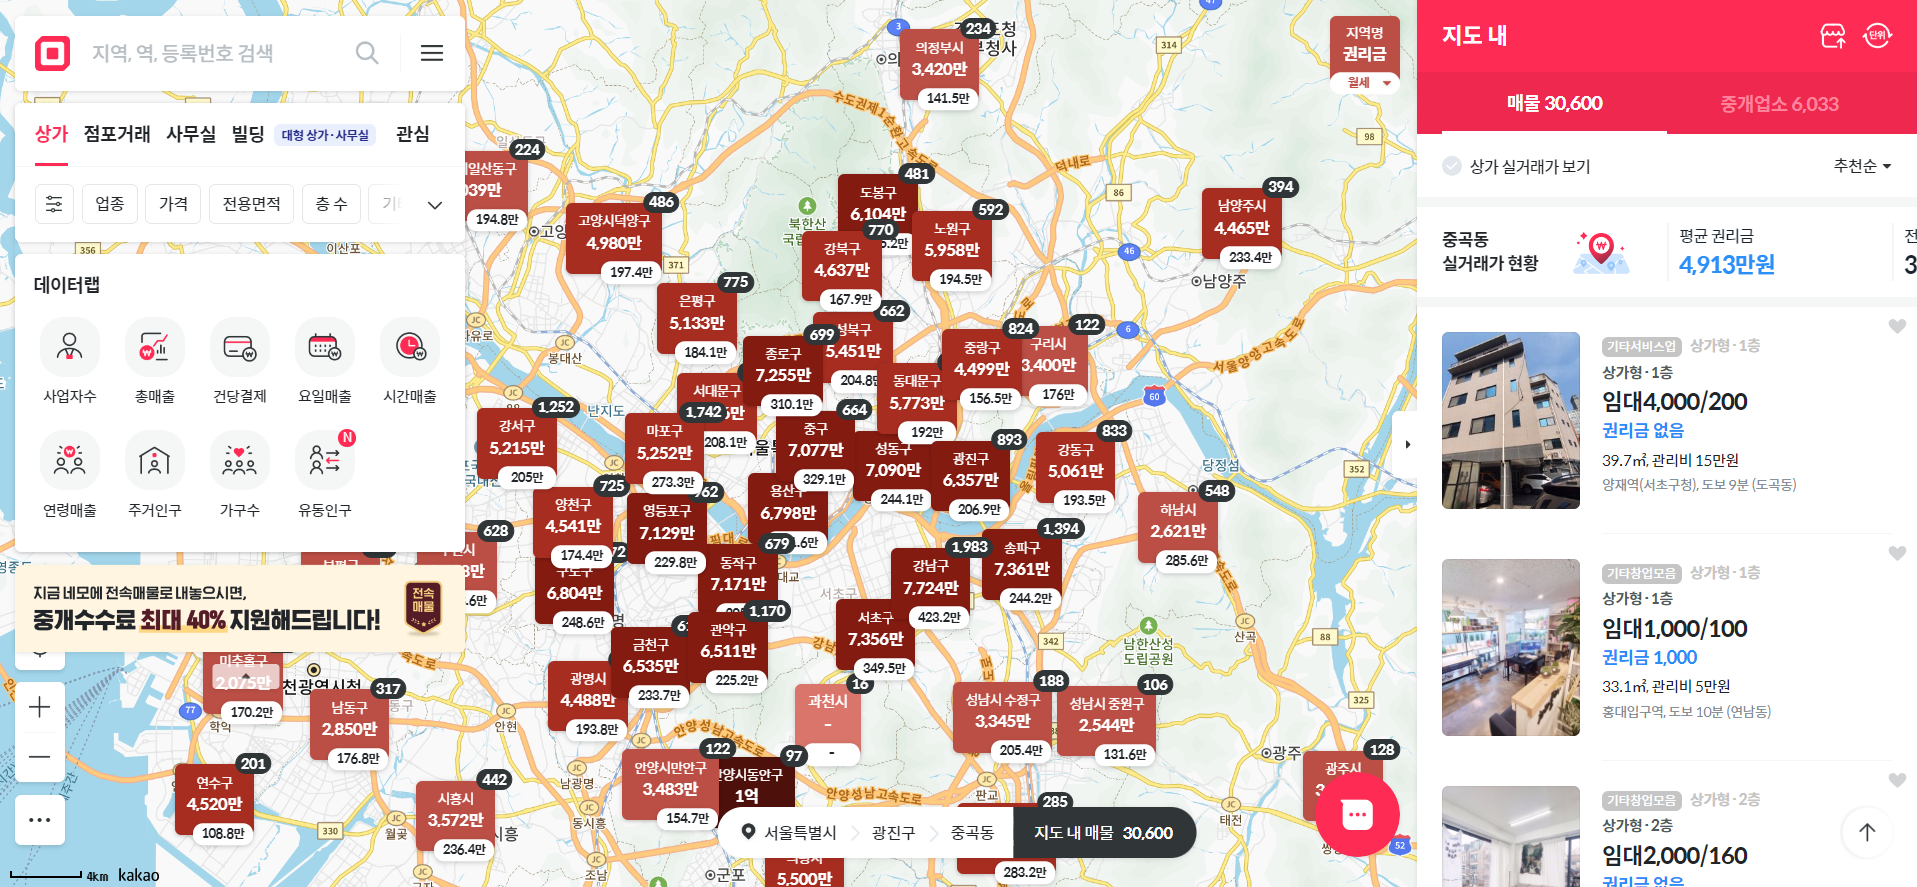

### Webdriver 실행

In [20]:
webdriver = wd.Chrome()

In [21]:
target_site = 'https://www.nemoapp.kr/Search?ArticleType=1&PageIndex=0&StoreTrade=false&SWLng=126.52185434831577&SWLat=37.35463178398812&NELng=127.63490104683103&NELat=37.766183919267355&Zoom=11&mode=1&category=1&list=true&articleId=&dataType='
webdriver.get(target_site)
time.sleep(2)

- 사이트 창에 로드된 모든 지역구에 대한 정보가 수집되는 상황
- 따라서, 우선 화면에 로드된 모든 정보를 수집하고 이후에 전처리 과정을 거쳐 서울시 지역구만 따로 필터링 진행

In [22]:
# 각 지역구에 해당되는 정보인 id값(searchPlaceHolder) 내 region-cluster class값
css_selector_gu = '#searchPlaceHolder div.region-cluster'
total_gu = webdriver.find_elements(By.CSS_SELECTOR, css_selector_gu)

len(total_gu)

48

In [23]:
# 데이터를 담을 수 있는 빈리스트 준비
gu_store_rent = list()
# 48개의 지역구에 대한 지역구명, 권리금, 월세 데이터 수집
for gu in total_gu:
    data = {
        'name' : gu.find_element(By.CSS_SELECTOR, 'span.name').text,
        'price' : gu.find_element(By.CSS_SELECTOR, 'span.price').text,
        'rent' : gu.find_element(By.CSS_SELECTOR, 'span.extended-data-averageMonthlyRent').text
        }
    gu_store_rent.append(data)

In [25]:
# gu_store_rent

In [35]:
# 사용완료된 webdriver 종료
webdriver.close()

In [26]:
# dataframe으로 변환
import pandas as pd
gu_store_rent_df = pd.DataFrame(gu_store_rent)

In [27]:
gu_store_rent_df.head()

,name,price,rent
0,과천시,-,-
1,의왕시,"5,500만",255만
2,안양시동안구,1억,405.1만
3,성남시 중원구,"2,544만",131.6만
4,광명시,"4,488만",193.8만


In [28]:
# 서울시 지역구에만 해당되는 지역으로 필터링하여 추출
seoul_gu_list = ['노원구', '양천구', '도봉구', '동작구', '은평구', '관악구', '성북구', '중랑구', '강동구', '구로구', '송파구', '강서구', '동대문구', '강북구', '서대문구', '금천구', '광진구', '성동구', '영등포구', '서초구', '용산구', '마포구', '강남구', '종로구', '중구']
seoul_gu_rent_df = gu_store_rent_df[gu_store_rent_df['name'].apply(lambda x : x in seoul_gu_list)].reset_index(drop=True)


In [30]:
# 총 25개의 서울시 자치구 데이터 수집 확인
len(seoul_gu_rent_df)

25

In [31]:
# 권리금과 월세 데이터의 값 서식이 문자열로 되어있고 'XX만원' 형태로 되어있음
# 추후 eda 과정에서 집계와 비교를 하기 위해 일반적인 숫자형태로 변환
seoul_gu_rent_df['price'] = seoul_gu_rent_df['price'].str.split('만').apply(lambda x : x[0]).str.replace(',', '').astype(int) * 10000
seoul_gu_rent_df['rent'] = seoul_gu_rent_df['rent'].str.split('만').apply(lambda x : x[0]).astype(float) * 10000

In [32]:
seoul_gu_rent_df.sort_values('rent', ascending = False)
# seoul_gu_rent_df.to_csv('지역구별_평균매매_임대료.csv', index = False)

,name,price,rent
24,강남구,77240000,4232000.0
19,서초구,73560000,3495000.0
7,중구,70770000,3291000.0
1,용산구,67980000,3116000.0
10,종로구,72550000,3101000.0
23,마포구,52520000,2733000.0
8,구로구,68040000,2486000.0
22,송파구,73610000,2442000.0
2,성동구,70900000,2441000.0
4,금천구,65350000,2337000.0
